<a href="https://colab.research.google.com/github/unkind58/Project_Football_Kits_Classifier/blob/main/football_kits_classifier_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yellow & green colored football kits classifier

## Main idea and stuffing

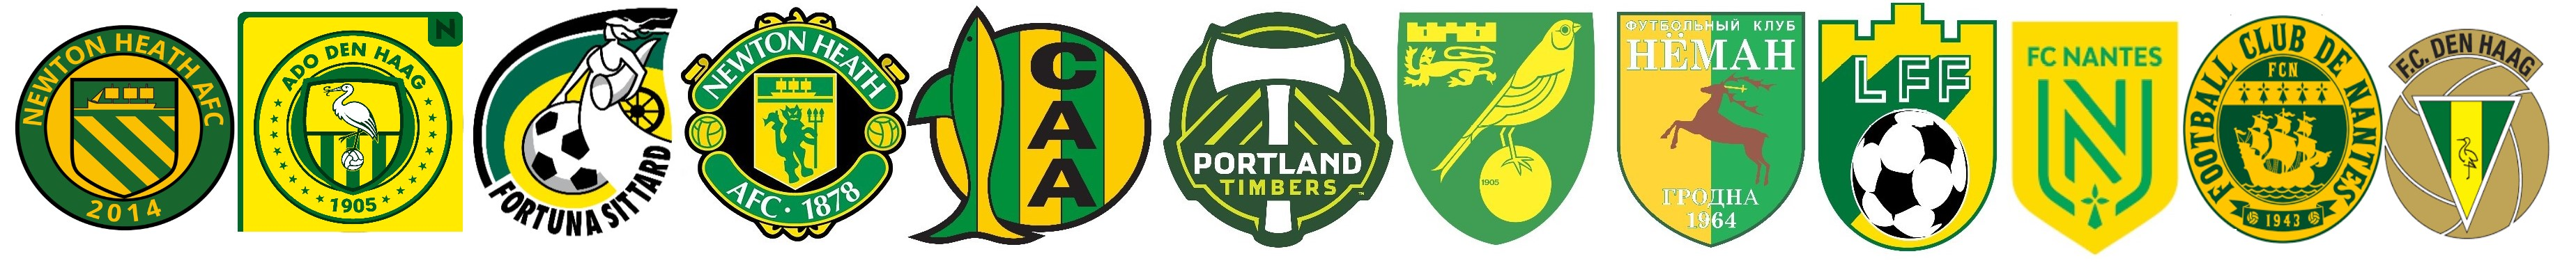

Multiclass classifier will predict from ten clubs which in different period of time have yellow & green colored football kits:

* Norwich City F.C.;
* West Bromwich Albion F.C.;
* FC Nantes;
* Club Atletico Aldosivi;
* Manchester United F.C.;
* ADO Den Haag;
* FC Neman Grodno;
* Portland Timbers;
* Sunderland A.F.C.
* Fortuna Sittard

## Libraries and dependencies

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

from google.colab import drive
from IPython.display import Image

Setting random seed and mounting Google Drive where all images are stored

In [ ]:
np.random.seed(seed=58)
drive.mount('/content/gdrive')

Creating paths for loading the data and saving the models weights

In [ ]:
path = Path('/content/gdrive/MyDrive/Projects/Data')
path_save = Path('/content/gdrive/MyDrive/Projects/models')

%cd /content/gdrive/MyDrive/Projects/Data

Exploring what are the labels of each of the folder


In [6]:
!ls

'ADO Den Haag'		  'Fortuna Sittard'	  'Portland Timbers'
'Club Atletico Aldosivi'  'Manchester United FC'  'Sunderland AFC'
'FC Nantes'		   models		  'West Bromwich Albion FC'
'FC Neman Grodno'	  'Norwich City FC'


## Batch Size & Image Data Bunch

Setting Batch Size

In [7]:
bs = 8

Creating Image Data Bunch with normalization, dividing train and validation sets as 80/20.

In [8]:
dls = ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  seed=58,
                                  size=224, 
                                  num_workers=4, 
                                  bs=bs).normalize(imagenet_stats)

Classes amount, sets shapes and classes names.

In [9]:
print(f'Total training set image amount: {len(dls.train_ds)}')
print(f'Total validation set image amount: {len(dls.valid_ds)}')
print(f'Total classes number: {dls.c}')
print()
dls.classes

Total training set image amount: 196
Total validation set image amount: 48
Total classes number: 10



['ADO Den Haag',
 'Club Atletico Aldosivi',
 'FC Nantes',
 'FC Neman Grodno',
 'Fortuna Sittard',
 'Manchester United FC',
 'Norwich City FC',
 'Portland Timbers',
 'Sunderland AFC',
 'West Bromwich Albion FC']

Taking a look at a Valdiation set random Data Batch.

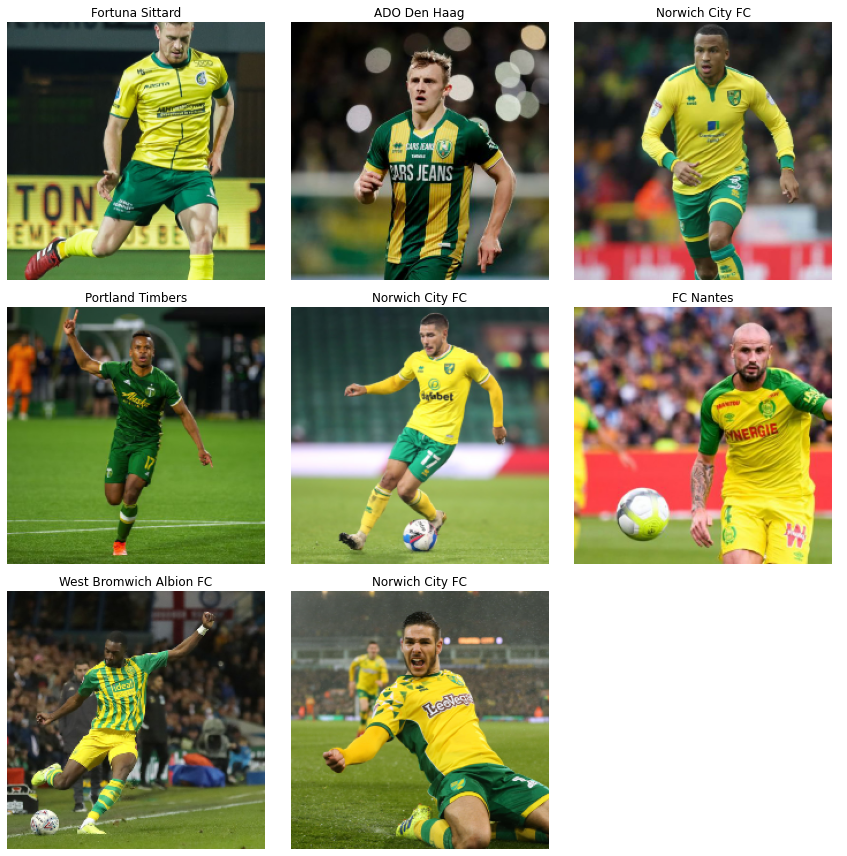

In [10]:
dls.show_batch(ds_type=DatasetType.Valid)

## Allotting train and validation DataFrames for plotting

In [11]:
%cd /content/gdrive/MyDrive/Projects

/content/gdrive/MyDrive/Projects


Import function for plotting from custom module and building custom seaborn colors palette

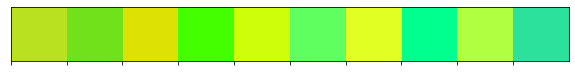

In [12]:
from plot_bar_h import *

colors = ['#BAE11F', '#70E11A', '#DDE104', '#44FF00', '#CEFF0A',  
          '#5FFF5F', '#E2FF23', '#00FF8C', '#B0FF41', '#2CE19C']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [13]:
train_data = pd.value_counts(dls.train_ds.y.items, sort=False);valid_data = pd.value_counts(dls.valid_ds.y.items, sort=False)
train_data.index = dls.classes; valid_data.index = dls.classes; 

df_train = pd.DataFrame.from_dict(train_data.to_dict(),orient='index',columns=['Amount'])
df_valid = pd.DataFrame.from_dict(valid_data.to_dict(),orient='index',columns=['Amount'])

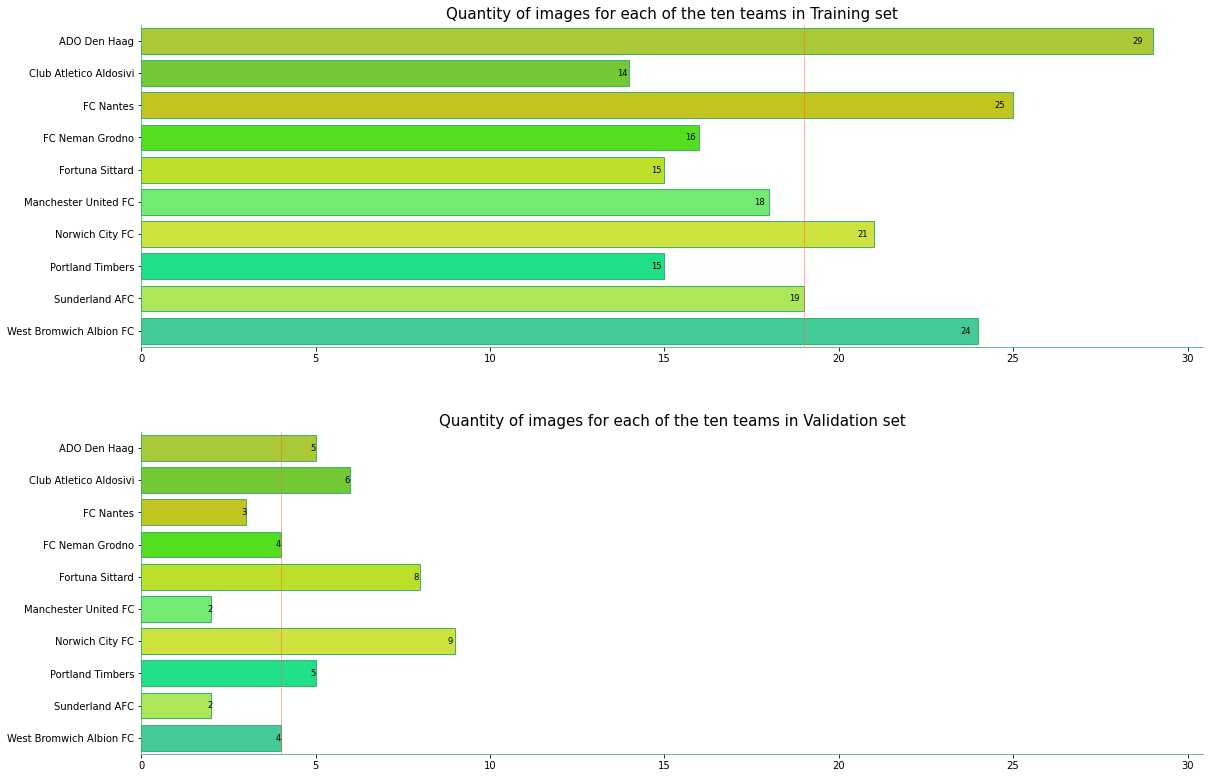

In [14]:
plot_barh(2,[[df_train['Amount'], df_train.index],
              [df_valid['Amount'], df_valid.index]], 
           ["Quantity of images for each of the ten teams in Training set", 
            "Quantity of images for each of the ten teams in Validation set"])

## Convolutional Neural Network

### Initialization

Initializing Convolutional Neural Network  using transfer learning with RESNET34 as a pretrained model. Evaluation metric is error rate.

In [15]:
learn = cnn_learner(dls, models.resnet34, metrics=error_rate)

CrossEntropyLoss() in practice, combines log_softmax and then nll_loss

In [16]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Creating a new directory for storing model's weights.


In [17]:
learn.model_dir='/content/gdrive/MyDrive/Projects/models'
learn.path/learn.model_dir

PosixPath('/content/gdrive/MyDrive/Projects/models')

### First model fit

Running 6 epochs with .fit_one_cycle() method.

In [18]:
learn.fit_one_cycle(6)

Ground truth VS. Predictions

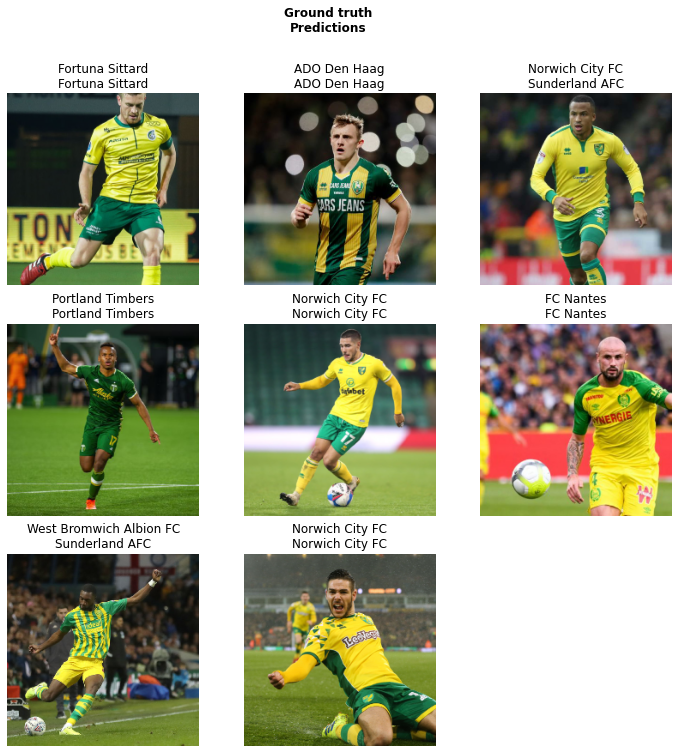

In [19]:
learn.show_results()

Saving first stage model, unfreezing last layers and finding optimal learning rate.

In [ ]:
learn.save('stage-1')

Unfreezing all model's layers

In [20]:
learn.unfreeze()

Computing optimal learning rate.

In [21]:
learn.lr_find()#stop_div=False, num_it=100) #  dls.valid_ds.items

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Plotting learning rate finder's computations.

Min numerical gradient: 7.59E-07
Min loss divided by 10: 2.09E-06


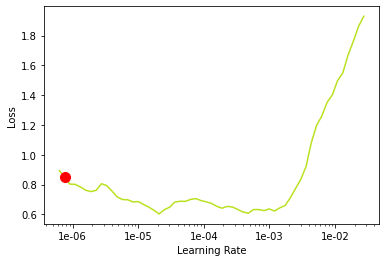

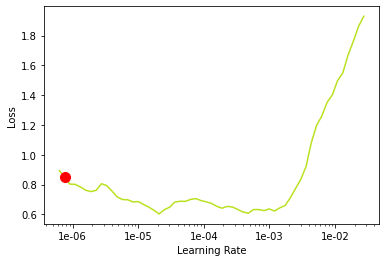

In [26]:
learn.recorder.plot(suggestion=True,return_fig=True)

### Second model fit

Slicing Learning rate from 1e-4 to 3e-4.

In [27]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,3e-4))

In [ ]:
learn.save('stage-2')

### Interim interpretation of model outputs

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

Visualizing confusion matrix with all predictions.

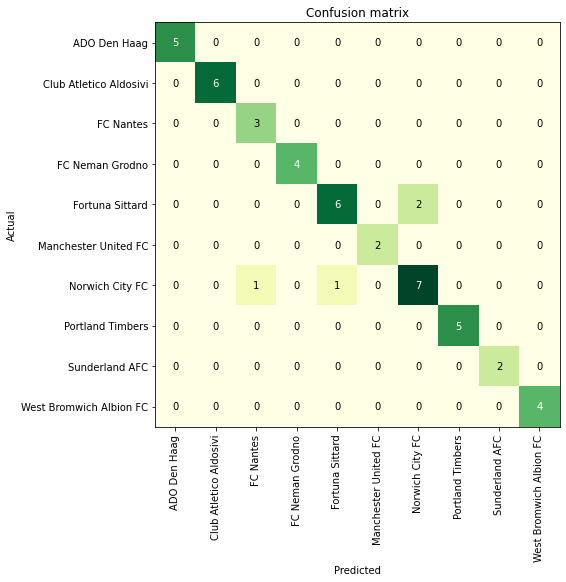

In [29]:
interp.plot_confusion_matrix(cmap='YlGn',figsize=(12,8))

Extracting images with heatmap effect which shows me what part of the image did the CNN focus on.

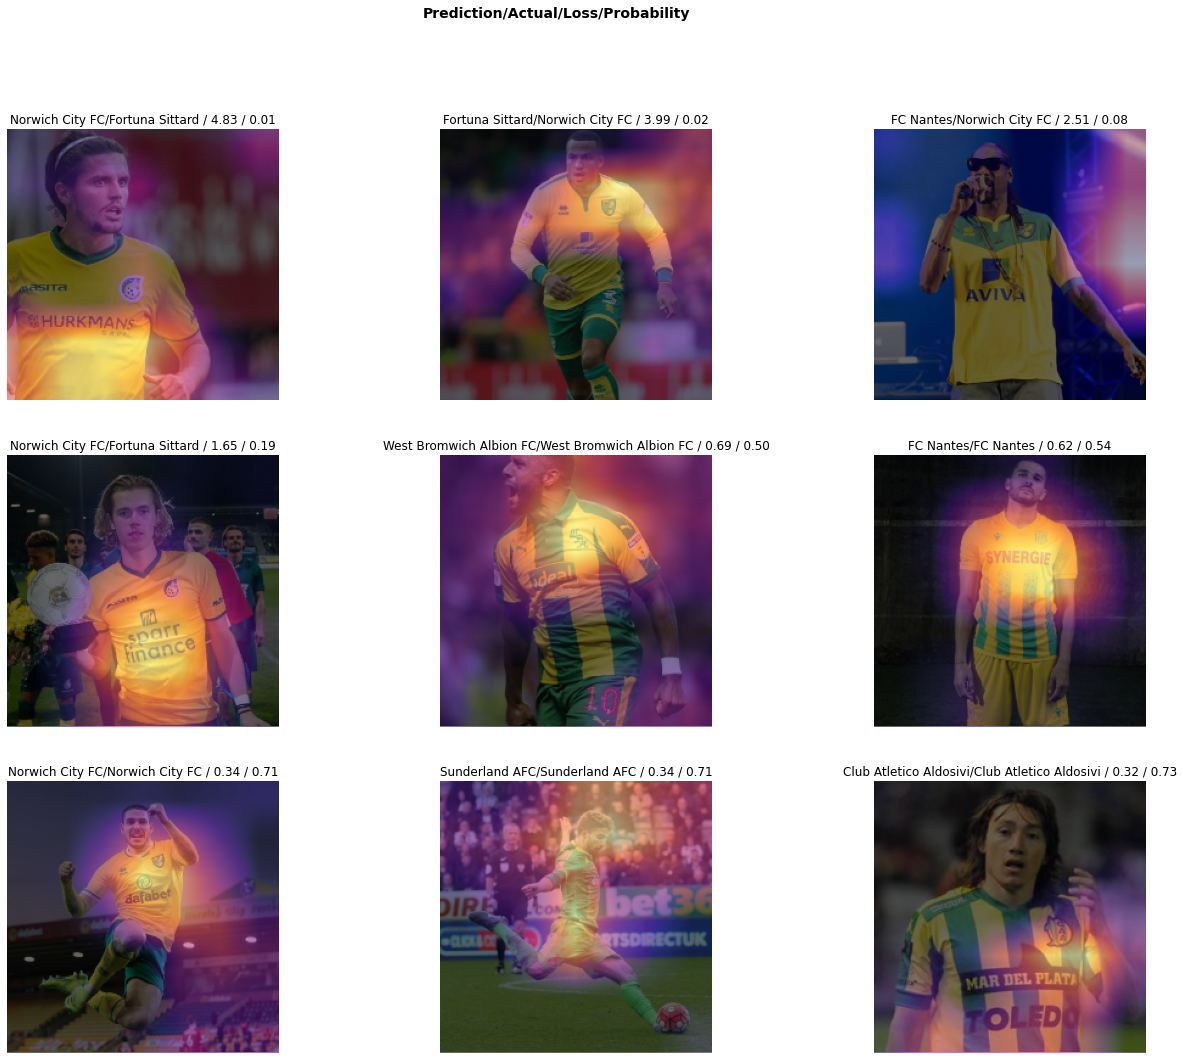

In [30]:
interp.plot_top_losses(9, figsize=(22,17),heatmap=True)

List of recognition mistakes with threshold of minimum 1 mistake per pair.

In [31]:
interp.most_confused(min_val=1)

[('Fortuna Sittard', 'Norwich City FC', 2),
 ('Norwich City FC', 'FC Nantes', 1),
 ('Norwich City FC', 'Fortuna Sittard', 1)]

In [35]:
learn.lr_find(stop_div=False, num_it=158)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


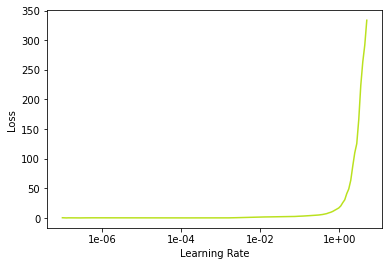

In [36]:
learn.recorder.plot( skip_start=0, skip_end=5) 

### Third model lfit

Takinf 1-e7 learning rate

In [37]:
learn.fit_one_cycle(5, max_lr=1e-7)

Overfitting as Validation error is rather high, training rather error low, so lets use weight decay

### Fourth model fit

In [38]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8, wd=0.2) 

In [40]:
learn.save('stage-3')

## Data augmentation

Trying  image augmentation

In [41]:
tfms = get_transforms(do_flip=False,max_rotate=10.,max_zoom=1.3,max_lighting=0.4, 
                      max_warp=0.1, p_affine=1., p_lighting=1.,)

In [42]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=58);src

ItemLists;

Train: ImageList (196 items)
Image (3, 2897, 1936),Image (3, 594, 401),Image (3, 612, 377),Image (3, 761, 564),Image (3, 612, 410)
Path: /content/gdrive/MyDrive/Projects/Data;

Valid: ImageList (48 items)
Image (3, 1888, 1152),Image (3, 410, 615),Image (3, 765, 1360),Image (3, 531, 800),Image (3, 691, 1024)
Path: /content/gdrive/MyDrive/Projects/Data;

Test: None

In [43]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()).transform(tfms, size=size, padding_mode=padding_mode).databunch(bs=bs).normalize(imagenet_stats)

In [44]:
data_augm = get_data(224, bs)

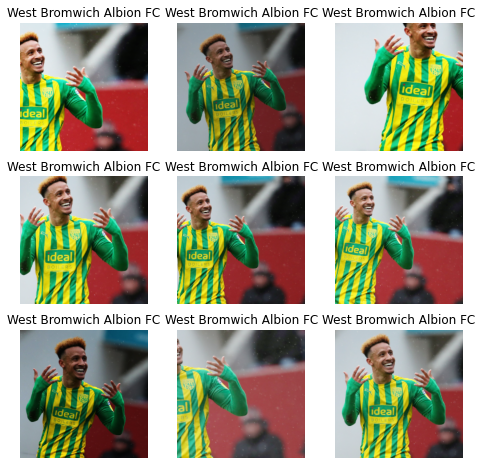

In [45]:
def _plot(i,j,ax):
    x,y = data_augm.train_ds[58]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [46]:
gc.collect()

19714

In [47]:
print(f'Total training set image amount: {len(data_augm.train_ds)}')
print(f'Total validation set image amount: {len(data_augm.valid_ds)}')

Total training set image amount: 196
Total validation set image amount: 48


Changing primary data with augmented data.

In [48]:
# learn_augm = cnn_learner(data_augm, models.resnet34, metrics=error_rate)
learn.data = data_augm

Taking a look at augmented images for training data.

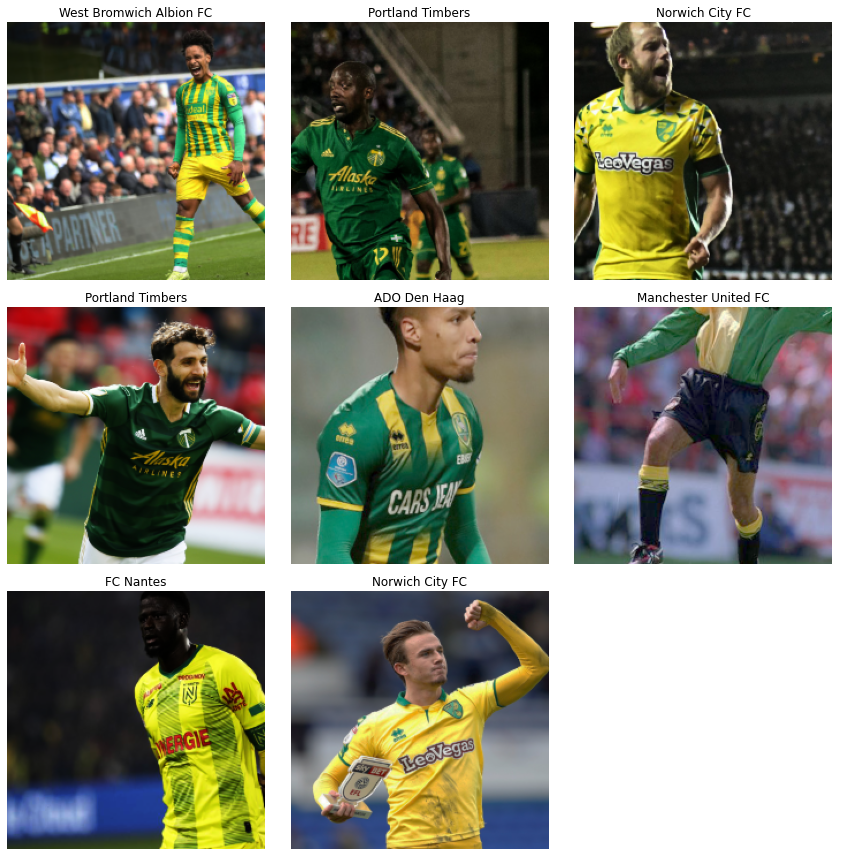

In [49]:
data_augm.show_batch(ds_type=DatasetType.Train)

### Single model fit with augmentated images

In [50]:
learn.fit_one_cycle(3, max_lr=slice(1e-7,1e-6), pct_start=0.8, wd=0.2)

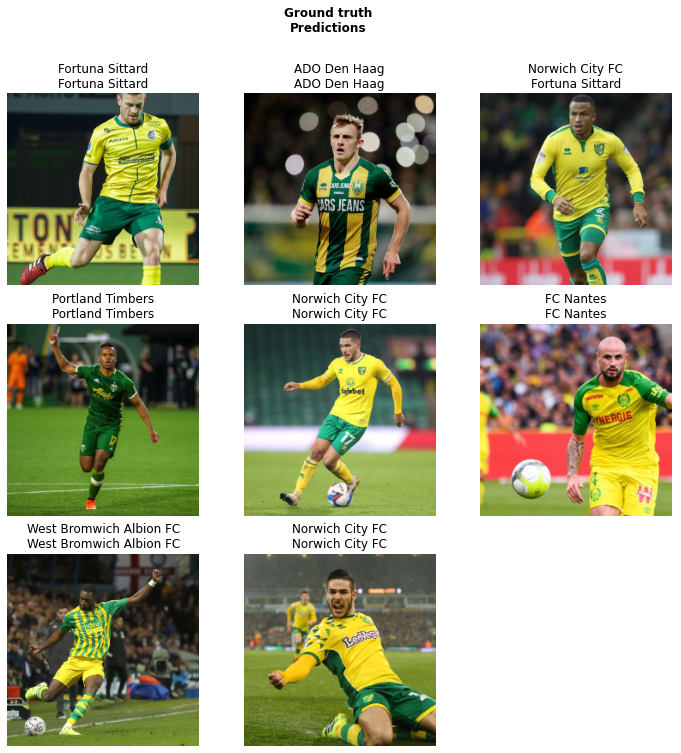

In [51]:
learn.show_results()

In [43]:
learn.save('stage-4')

In [52]:
learn.lr_find(stop_div=False, num_it=158)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


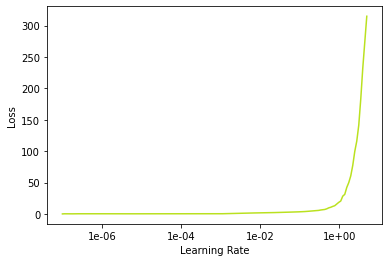

In [53]:
learn.recorder.plot(skip_start=0, skip_end=5)

### Pre-final interpretation of model outputs

In [54]:
interp_augm = ClassificationInterpretation.from_learner(learn)

In [55]:
interp_augm.most_confused(min_val=1)

[('Fortuna Sittard', 'Norwich City FC', 1),
 ('Norwich City FC', 'Fortuna Sittard', 1),
 ('Norwich City FC', 'Manchester United FC', 1)]

Only 3 mistakes in the end

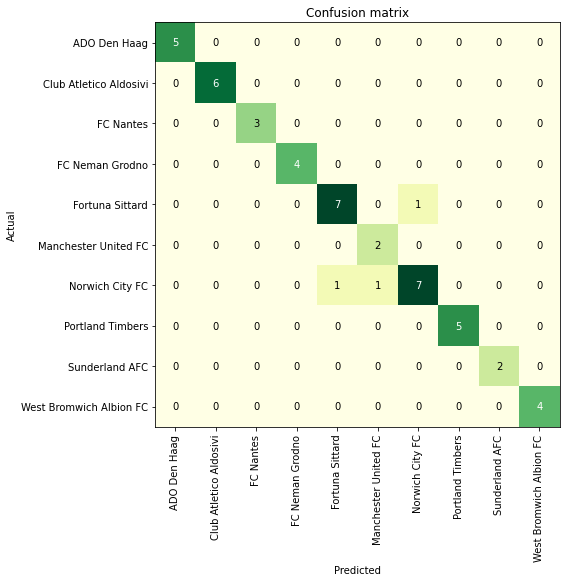

In [56]:
interp_augm.plot_confusion_matrix(cmap='YlGn',figsize=(12,8))

# Last several fits and final error rate

Changing image size from 224 to 352

In [57]:
data_augm2 = get_data(352,bs)
learn.data = data_augm2

In [58]:
learn.fit_one_cycle(3, max_lr=slice(1e-2,1e-1), pct_start=0.8, wd=0.2)

Load the latest model with 0.0625 error rate, as model above went bad

In [ ]:
learn.load('stage-4') # if goes bad 

In [65]:
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-6), pct_start=0.8, wd=0.2)

---

Error rate - 0.062500

---